<h1 align="center">BlenderMapDEM Workflow Demonstration</h3>

# What is this File?
This file is meant to be used as a demonstration showing how to utilize the functions within this `BlenderMapDEM` package in a cohesive manner in order to fetch DEM data of any extent and render it using Blender.

The demonstration seen in this file assumes that the package has already been installed properly as specified in the [installation]() section of the main `README.md` file. This process entails installing the package through git and copying the `renderDEM.py` file to Blender's module folder.

# Workflow Demonstration
The workflow for using these functions can be divided into three stages. In the first stage you fetch a .geotiff image and perform geospatial operations on it that make use of its geographic metadata. In the second stage you convert this DEM .geotiff into an image and render it using Blender. Finally in the third stage you georeference this hillshade render back into a .geotiff if you wish to make use of it in GIS programs for cartography purposes.

Keep in mind that while the process demonstrated here seems long and tedious, all these functions could be placed in one python file (or jupyter notebook) to run one after the other and all a user would have to do is specify a new extent to be fetched to get DEM images for different locations.

The following tasks will be demonstrated in this document:
- Fetching a DEM .geotiff image using `fetchDEM()`
- Viewing the data using `describeDEM()` and `plotDEM()`
- Fixing extreme 'nodata' values using `fixNoData()`
- Clipping the DEM to a more focused extent using `clipDEM()`
- (Demonstrating but not using) reprojecting the DEM to a new EPSG crs using `reprojectDEM()`
- Converting the DEM .geotiff to a usable image with `geotiffToImage()`
- (Demonstrating but not using) reducing the image resolution of the DEM with `simplifyDEM()`
- Rendering a hillshade image based off an input DEM image using Blender with `renderDEM()`
- Georeferencing a hillshade image using the DEM .geotiff that was used to create it using `georeferenceImage()`
<br/>

## Stage 1: Fetching DEM .geotiff Image and Performing Geospatial Operations

Begin by importing `BlenderMapDEM` and use `fetchDEM()` to get a .geotiff raster image of a chosen DEM extent saved to a specified directory. All directories within this demonstration will be relative to this `demo/` folder within the repository.

Note that while they are separate functions, `fetchDEM()` and `locationBounds()` can be used together if you wish to save yourself the trouble of finding lat and long bounds of an area on your own. Note this is most useful for clearly defined places, if you want to produce a DEM of an obscure or specific extent it is best to define your own coordinates.

This .geotiff file, while not viewable in standard image editors and Blender at this stage, is able be manipulated and explored using geospatial operations that make use of its metadata.

In [1]:
# Import package
from BlenderMapDEM import *

In [3]:
# Get DEM map using fetchDEM() using boundaries retrieved from locationBounds()
fetchDEM(north_bound = locationBounds('Barbados')['north'],
         south_bound = locationBounds('Barbados')['south'],
         east_bound = locationBounds('Barbados')['east'],
         west_bound = locationBounds('Barbados')['west'],
         API_Key = '7da2375367b589517231f8fee1ae6b7c', # Input API key
         dataset = 'SRTMGL1', # Specify DEM dataset, in this case SRTM 30m resolution
         output_dir = './data/BarbadosDEM.tif') # Specify output directory for map

This .geotiff DEM file can now be opened in GIS software, however there is still work to be done to prepare the DEM for input into Blender.

![alt text](imgs/qgis.png "DEM openned in QGIS")

The following functions use the generated .geotiff image to perform a variety of tasks to manipulate or better understand the data:

- Use `plotDEM()` to quickly visualize the data to get a general overview
- Use `describeDEM()` to describe the data and display key information
- Use `fixNoData()` to set the 'nodata' values to a specific value (usually 0)
- Use `clipDEM()` to clip a section of the .geotiff according to shapefile geometry
- Use `reprojectDEM()` to reproject .geotiff to a different EPSG crs code
<br/>

### Using plotDEM()
`plotDEM()` can be useful to quickly visualize the data before rendering, as well as to view a histogram of elevation value frequencies.

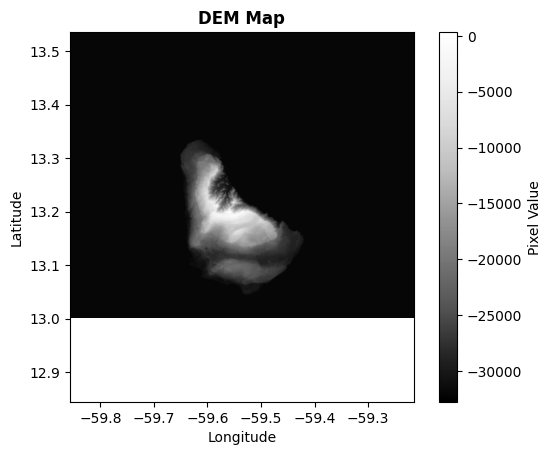

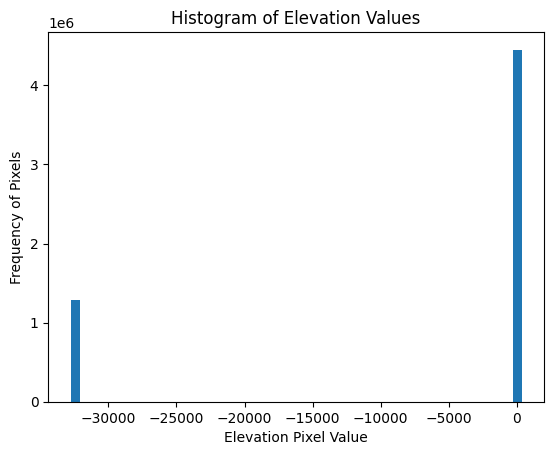

In [4]:
# Using plotDEM() to get a general overview of the DEM file visually
plotDEM(geotiff_dir = './data/BarbadosDEM.tif')

Hmmm, kinda looks weird but we will move on.
<br/>

### Using describeDEM()
`describeDEM()` can be useful for seeing important information regarding the DEM .geotiff such as min and max elevation, the dimensions of the image, how many color bands are present (almost always 1 for DEM's), the top left origin location, bounds of the image, what 'nodata' pixel values are set to, and the current crs.

In [5]:
# Using describeDEM() to get key information about the DEM file
describeDEM(geotiff_dir = './data/BarbadosDEM.tif')

{'min_elevation': -32768,
 'max_elevation': 342,
 'width': 2484,
 'height': 2309,
 'bands': 1,
 'origin': (13.535138888882734, -59.85624999998409),
 'bounds': {'top': 13.535138888882734,
  'bottom': 12.845138888882643,
  'left': -59.85624999998409,
  'right': -59.21486111109511},
 'nodata': -32768.0,
 'crs': CRS.from_epsg(4326)}

<br/>

Okay so we visualized and viewed the data, but there's a problem! Do you see the missing bottom section and the ridiculous distribution of pixel values seen in `plotDEM()`. Do you also see where `describeDEM()` returns `nodata: -32768`? This is because the `nodata` value of this dataset is set so low that it is messing with the distribution of elevation values when plotted and analyzed. This is happening because our DEM image extends off the coast where there is no elevation data.

There will also be issues when this DEM .geotiff is later being converted to an image using `geotiffToImage()`. It will have trouble converting it properly because the values of `nodata` pixels is set to a ridiculously low number like -32768. For reasons that are slightly complicated, the `geotiffToImage()` function that will be used later converts the DEM from a color depth of 16 bits to a color depth of 8 bits and thus rescales the height values to be between 0-255. Such a low `nodata` value will result in an overflow and mess up the scaling of height values resulting in an image with either all black or all white elevation pixel values.

To fix this we can use the `fixNoData()` function to "fix" all `nodata` values to be 0 which meshes well with the conversion to 8-bit color depth and makes the distribution of elevations much more intuitive. By default the function overwrites the input DEM .geotiff with `nodata` values of 0. Other values can be used however it is **strongly recommended** to leave it at 0. 
<br/>

### Using fixNoData()

In [6]:
# Using fixNoData() to set 'nodata' values to 0
fixNoData(geotiff_dir = './data/BarbadosDEM.tif', nodata_value = 0)

Now if we use `describeDEM()` again to see what the `nodata` value is, we can see it is now set to 0. We can also plot the data again using `plotDEM()` to view it.

In [8]:
# Using describeDEM() and plotDEM() to check 'nodata' value
describeDEM(geotiff_dir = './data/BarbadosDEM.tif')['nodata']

0.0

The DEM plot and `nodata` values look good now, but it is too zoomed out! Lets clip the DEM .geotiff according to a geometry file to cover a smaller extent.
<br/>

### Using clipDEM()
`clipeDEM()` can be very helpful for clipping the DEM .geotiff to contain only a specified area of interest. The function can be used with `crop = True` (default) to crop the extent of the DEM .geotiff to the clipped area, or `crop = False` to keep the original extent but set all height values outside the clipped area to 0 creating an "island" effect. We want a more focused extent so we will leave `crop` as True.

The geometry files containing clipping geometries can be stored in either .geojson, .json, or .shp files. (.geojson is recommended for simplicity). [This website](https://geojson.io/) can be used to create these clipping geometries.

![alt text](imgs/geojson.png "Using geojson.io")

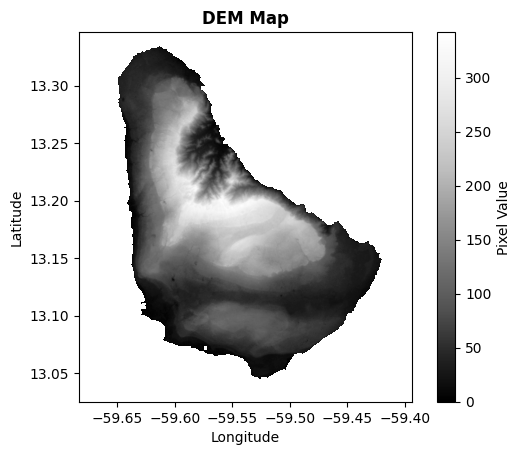

In [9]:
# Using clipDEM() to clip original DEM by clipping geometry
clipDEM(geotiff_dir = './data/BarbadosDEM.tif',
        geometry_dir = './data/clip_geometry.geojson',
        output_dir = './data/BarbadosDEM_clipped.tif')

# Using plotDEM() to view our new clipped DEM .geotiff
plotDEM(geotiff_dir = './data/BarbadosDEM_clipped.tif', histogram = False)

Great! Now we have a DEM map of Barbados that is clipped properly.
<br/>

### Using reprojectDEM()
`reprojectDEM()` can be used to reproject an input .geotiff to a new EPSG crs coordinate system. All it takes is an input .geotiff directory, the EPSG crs code you wish to convert to (as either an integer or string), and an output directory for the converted .geotiff file.

In [17]:
# Using reprojectDEM() to convert .geotiff to new crs
reprojectDEM(geotiff_dir = './data/BarbadosDEM_clipped.tif',
             epsg_num = 21292, # EPSG code for Barbados National Grid
             output_dir = './data/BarbadosDEM_reprojected.tif')

# Using describeDEM() to verify new crs value
describeDEM(geotiff_dir = './data/BarbadosDEM_reprojected.tif')['crs']

CRS.from_epsg(21292)

Great! Where before the EPSG code was set to 4326, it is now set to 21292 which is the EPSG code for Barbados National Grid. This was just done for demonstration however as I would like to keep the DEM in its original coordinate system.
<br/>

## Stage 2: Converting .geotiff to Image and Rendering using Blender

While you could open up the DEM .geotiff file in any GIS software and export it as an image, this is tedious and requires extra effort for a task that could be automated!

We can use `geotiffToImage()` to convert the .geotiff DEM file into an image format that is readable by Blender.

**Important:** it is crucial that you keep the DEM .geotiff file you are converting to an image here if you wish to later georeference the final hillshade image. Once this DEM is converted to an image it loses all relevant geospatial information, so by keeping the DEM .geotiff used to create the hillshade image you can imbue this geospatial metadata back into the hillshade image if you wish to by using `georeferenceImage()`.

In [15]:
# Using geotiffToImage() to generate viewable image file from .geotiff DEM file
geotiffToImage(geotiff_dir = './data/BarbadosDEM_clipped.tif',
               output_dir = './data/BarbadosDEM_image.png')

Now we have an image that is able to be opened by non-GIS programs (such as Blender)!

<img src="./imgs/openable_image.png" alt= “” width="50%" height="50%">

### (Optionally) Using simplifyDEM()

We can use `simplifyDEM()` to downscale the image file to a lower resolution which lessens the resource requirements of your computer when rendering an image (a 2000x2000 pixel image is easier to render than a 5000x5000 pixel image)

Ideally you should not use this function to retain the highest quality however it can be helpful depending on the computer to speed up render times.

In [16]:
# Using simplifyDEM() to downscale DEM image file to lower resolution
simplifyDEM(dem_dir = './data/BarbadosDEM_image.png',
            output_dir = './data/BarbadosDEM_image_downscaled.png',
            reduction_factor = 2) # This result in an image with half the original resolution

Now we have a downscaled image with half the resolution of the original file generated by the `geotiffToImage()` function.

![alt text](imgs/downscaled_image.png "Downscaled DEM image")

This file will not be used to be fed into Blender because the normal DEM image already has a quite small resolution, this was just done for demonstration. We are finally ready to feed our prepared DEM image into Blender!
<br/>

### Rendering using the `renderDEM()` Function
The `renderDEM()` function uses the `subprocess` module to automate running Blender using the terminal by telling Blender to run the code within the `renderDEM.py` file which was added to Blender's modules folder. This function requires you to specify the path to the `blender.exe` file within the `blender_dir` parameter.

It is important for this function, because it is really being run by Blender and not by code relative to your working directory, that you specify **absolute directory paths** for the parameters of `blender_dir`, `dem_dir`, and `output_dir`.

The following code will use the `renderDEM()` function to render a hillshade map using the DEM we obtained from `fetchDEM()` and converted to an image with `geotiffToImage()`:

In [18]:
# Specifying paths of blender.exe, input DEM image, and output rendered image
blender = 'C:/Program Files/Blender Foundation/Blender 3.4/blender.exe'
DEM =  'C:\Home\Documents\BlenderMapDEM\demo\data\BarbadosDEM_image.png'
output = 'C:\Home\Documents\BlenderMapDEM\demo\data\Barbados_render.png'

# Using renderDEM to run blender from within this python script
renderDEM(blender_dir = blender,
          dem_dir = DEM,
          output_dir = output,
          exaggeration = 1.0,
          resolution_scale = 100,
          samples = 5)

This render was done with very minimal quality settings and it still looks great!

<img src="./data/Barbados_render.png" alt= “” width="75%" height="75%">
<br/>

## Stage 3: Georeferencing the Hillshade Image
This hillshade, while beautiful as an image on its own, could be of better use for GIS purposes if it contained the geospatial metadata found within the original DEM .geotiff we obtained from OpenTopography. We can use the `georeferenceImage()` function to do just that.

`georeferenceImage()` takes in the directory path to your hillshade image, the directory path to the DEM .geotiff you wish to copy metadata from, and an output directory path where the new georeferenced .geotiff containing your hillshade should be saved.

It is **very important** that the .geotiff you are obtaining metadata from is the **same .geotiff you converted to an image** and used to generate the hillshade in the first place. This is because it has all the correct geospatial metadata we are just re-attributing to the hillshade image file.

In [ ]:
# Using georeferenceImage() to imbue a hillshade image with geospatial metadata from an input DEM .geotiff file
georeferenceImage(hillshade_dir = './data/Barbados_render.png',
                  geotiff_dir = './data/BarbadosDEM_clipped.tif',
                  output_dir = './data/Barbados_georeferenced')

This georeferenced image can now be imported into GIS programs such as QGIS and it will be georeferenced to the correct spatial extent on the surface of the earth. It can then be used to overlay on top of other imagery such as OpenStreetMap data or satellite imagery.

The following picture shows the georeferenced hillshade render being overlayed on top of OpenStreetMap data within QGIS. The hillshade layer is set to the blending mode "Multiply" and has its brightness raised from 0 to 54.

![alt text](imgs/overlay.png "Overlaying hillshade on OSM data in QGIS")

We are done! The previous steps can be repeated with any input DEM image to create a beautiful hillshade render of any spatial extent.